In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# 結果を保存する変数
results = []

# モデルの評価結果を保存する関数
def save_results(results, model_name, y_test, y_pred):
    results.append({
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

# モデルの学習時間を保存する関数
def save_time(results, model_name, time):
    results.append({
        "model": model_name,
        "time": time
    })

In [3]:
# データの読み込み
#data = pd.read_csv('UNSW_NB15/UNSW_NB15_training-set.csv')
data = pd.read_csv('UNSW_NB15/UNSW_NB15_testing-set.csv')

# データの確認
print(f"data shape is : {data.shape}")
#print(data.head())


data shape is : (175341, 45)


In [4]:
# データの前処理
target = data['label']

# one-hot encoding
data = pd.get_dummies(data, columns=["proto", "service", "state", "is_sm_ips_ports", "is_ftp_login"])

# データの確認
print(f"data shape is : {data.shape}")

# 不要な列の削除
data = data.drop(['id', "attack_cat", "label"], axis=1)

# データの確認
#print(f"data shape is : {data.shape}")
#print(data.head())

# データを pickle ファイルに保存
data.to_pickle("pickles/data_UNSW.pkl")
target.to_pickle("pickles/target_UNSW.pkl")


data shape is : (175341, 201)


In [5]:
# pickle ファイルからデータを読み込む
data_loaded = pd.read_pickle("pickles/data_NSL.pkl")
target_loaded = pd.read_pickle("pickles/target_NSL.pkl")

# 読み込んだデータの確認
print(data_loaded.shape)
print(target_loaded.shape)

(125973, 124)
(125973,)


In [42]:
# trainデータを分割して学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# indexのリセット
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# データの確認
print(f"X_train shape is : {X_train.shape}")
print(f"X_test shape is : {X_test.shape}")
print(f"y_train shape is : {y_train.shape}")
print(f"y_test shape is : {y_test.shape}")

X_train shape is : (122738, 198)
X_test shape is : (52603, 198)
y_train shape is : (122738,)
y_test shape is : (52603,)


Accuracy of RandomForest: 0.9595650438187936


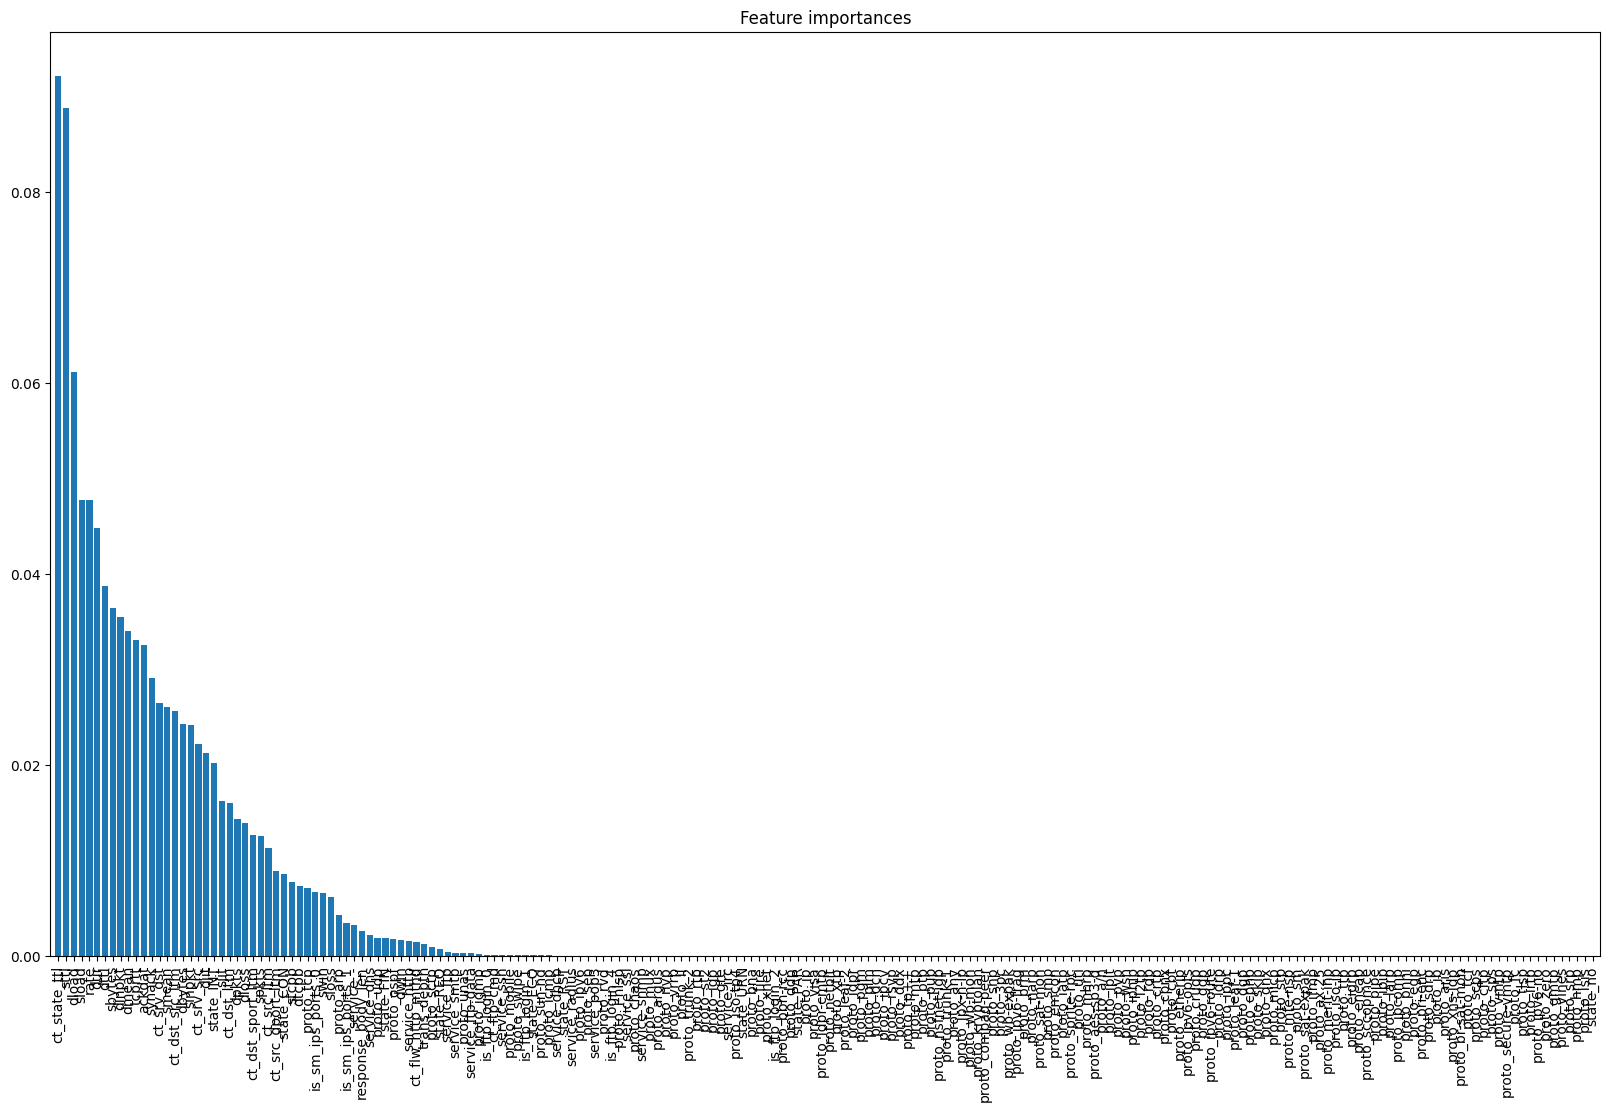

In [43]:
######################
#RandomForestによる特徴量重要度の算出
######################

# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# numpy配列をDataFrameに変換
X_train = pd.DataFrame(X_train, columns=data.columns)
X_test = pd.DataFrame(X_test, columns=data.columns)

# ランダムフォレストの作成
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ランダムフォレストの精度
y_pred = model.predict(X_test)
print(f"Accuracy of RandomForest: {accuracy_score(y_test, y_pred)}")

# 特徴量の重要度
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 12))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), data.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [44]:
#############################
# ナイーブなIsolation Forest
#############################

# 異常と正常データに分割
X_train_normal = X_train.loc[y_train == 0]
X_train_anomaly = X_train.loc[y_train == 1]
print(f"Normal data shape: {X_train_normal.shape}")
print(f"Attack data shape: {X_train_anomaly.shape}")

# モデルの作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal)
model_anomaly.fit(X_train_anomaly)

# テストデータでの精度(特徴量選択なし)
y_pred_normal = model_normal.predict(X_test)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

y_pred_anomaly = model_anomaly.predict(X_test)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

print(f"Accuracy of Normal machine: {accuracy_score(y_test, y_pred_normal)}")
print(f"Accuracy of Attack machine: {accuracy_score(y_test, y_pred_anomaly)}")

# 結果を組み合わせた精度
# (Normal, Attack) = (0, 0) -> 0 (normal)
# (Normal, Attack) = (0, 1) -> 1（anomaly）
# (Normal, Attack) = (1, 0) -> -1 (unkown)
# (Normal, Attack) = (1, 1) -> 1 (anomaly)

y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 0), 0, 0)
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 1), 1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 0), -1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 1), 1, y_pred)

print(f"Accuracy of Combined machine: {accuracy_score(y_test, y_pred)}")

# 結果の保存
save_results(results, "naive", y_test, y_pred)

Normal data shape: (39308, 198)
Attack data shape: (83430, 198)
Accuracy of Normal machine: 0.5900423930194095
Accuracy of Attack machine: 0.7684542706689732
Accuracy of Combined machine: 0.7506415983879247


Accuracy of Iforest with LogisticRegression: 0.8685436191852176


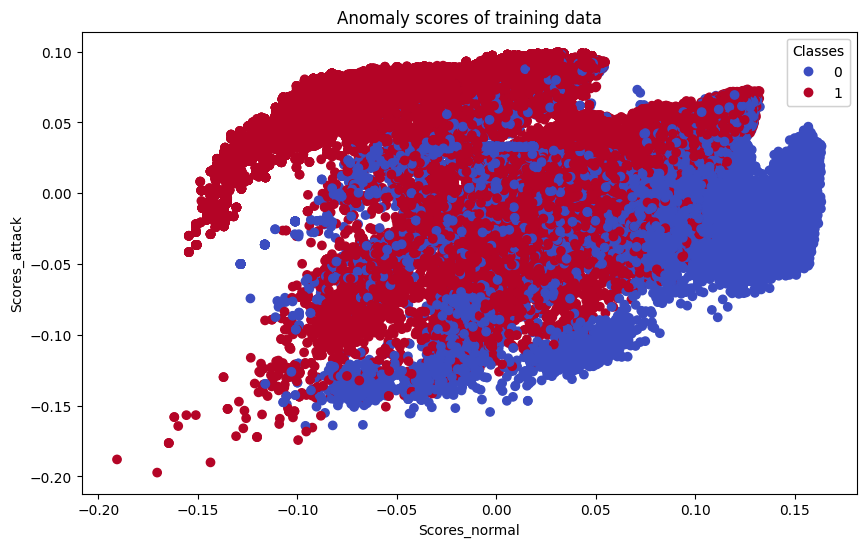

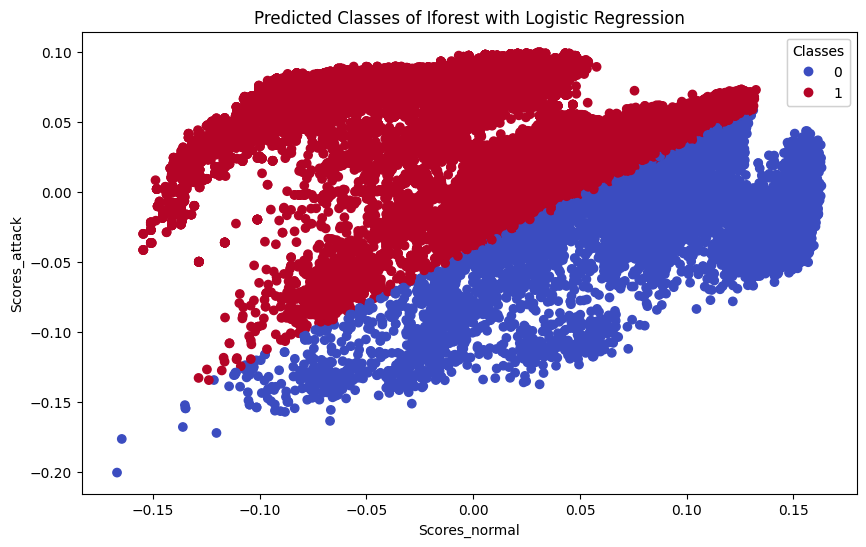

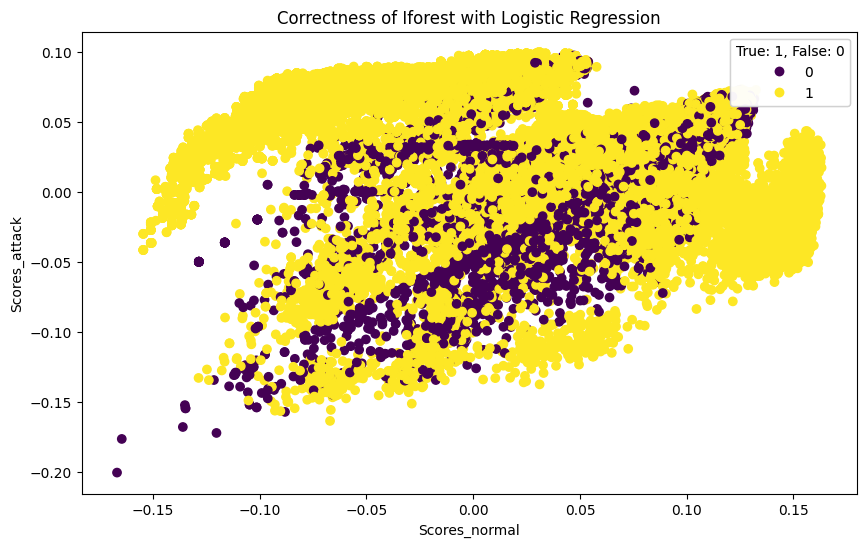

In [45]:
######################################
# 特徴量選択なし、ロジスティック回帰で判定
######################################

# 異常スコア取得用のモデルを作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal)
model_anomaly.fit(X_train_anomaly)

# トレーニングデータの異常スコアを取得
scores_train_normal = model_normal.decision_function(X_train)
scores_train_anomaly = model_anomaly.decision_function(X_train)
scores_train = np.column_stack((scores_train_normal, scores_train_anomaly))

# テストデータの異常スコアを取得
scores_normal = model_normal.decision_function(X_test)
Scores_attack = model_anomaly.decision_function(X_test)
scores = np.column_stack((scores_normal, Scores_attack))

# ロジスティック回帰を用いてラベルを予測

# ロジスティック回帰モデルの作成
model_LR = LogisticRegression()
model_LR.fit(scores_train, y_train)

# ラベルの予測
y_pred = model_LR.predict(scores)
print(f"Accuracy of Iforest with LogisticRegression: {accuracy_score(y_test, y_pred)}")

# 教師データの異常スコアをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores_train[:, 0], scores_train[:, 1], c=y_train, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.title("Anomaly scores of training data")
plt.show()

# 予測したラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
plt.title("Predicted Classes of Iforest with Logistic Regression")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

# 正解不正解をプロット
labels = np.where(y_test == y_pred, 1, 0) # 1: 正解, 0: 不正解

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
plt.title("Correctness of Iforest with Logistic Regression")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()

# 結果の保存
save_results(results, "no selection with LogisticRegression", y_test, y_pred)


In [46]:
#######################
# 特徴量選択あり、ナイーブ
#######################

# 不必要な特徴量を削除
# 上位10%の特徴量を選択
important_features = importances > np.percentile(importances, 90)

X_test_dropped = X_test[data.columns[important_features]]
X_train_anomaly_dropped = X_train_anomaly[data.columns[important_features]]
X_train_normal_dropped = X_train_normal[data.columns[important_features]]

# モデルの作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal_dropped)
model_anomaly.fit(X_train_anomaly_dropped)

# テストデータでの精度
y_pred_normal = model_normal.predict(X_test_dropped)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

y_pred_anomaly = model_anomaly.predict(X_test_dropped)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

print(f"Accuracy of normal: {accuracy_score(y_test, y_pred_normal)}")
print(f"Accuracy of attack: {accuracy_score(y_test, y_pred_anomaly)}")

# 結果を組み合わせた精度
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 0), 0, 0)
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 1), 1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 0), -1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 1), 1, y_pred)

print(f"Accuracy of combined machine: {accuracy_score(y_test, y_pred)}")

# 結果の保存
save_results(results, "feature selection", y_test, y_pred)

Accuracy of normal: 0.5541128832956296
Accuracy of attack: 0.8455791494781666
Accuracy of combined machine: 0.8216261429956466


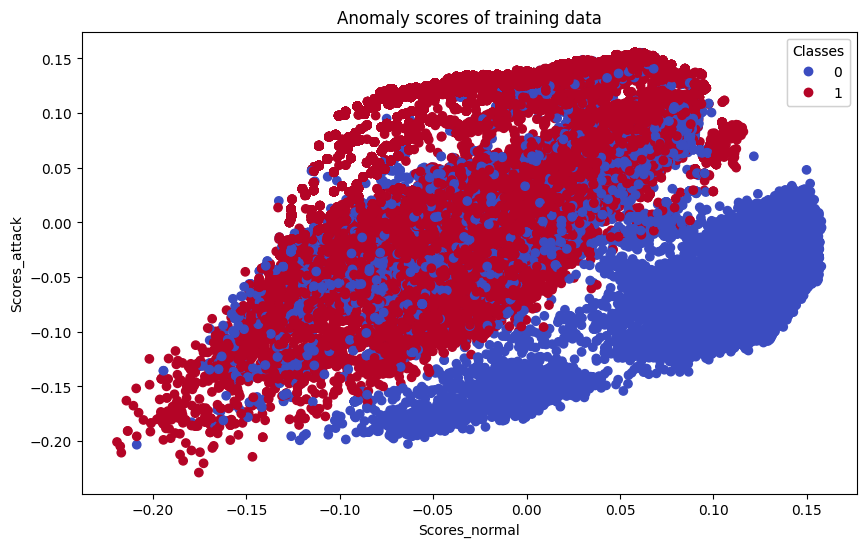

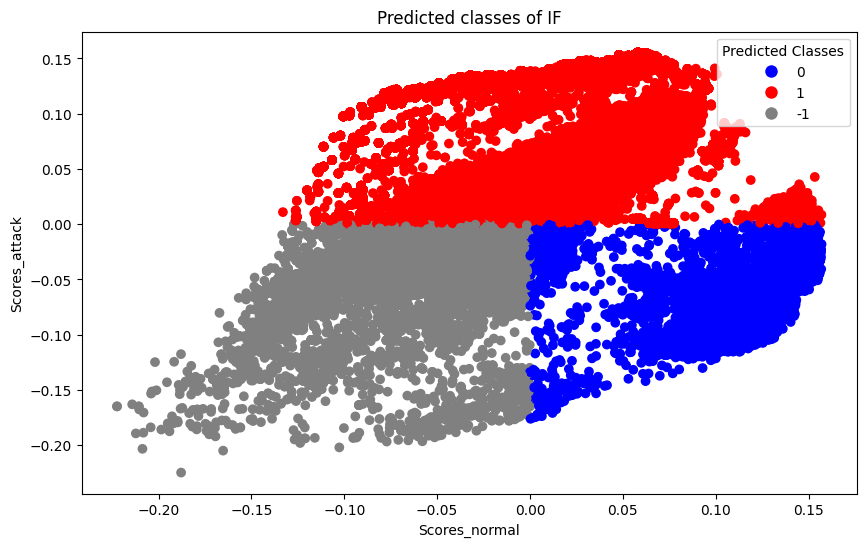

In [47]:
######################################  
# データのプロット
######################################

# 異常スコア取得用のモデルを作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal_dropped)
model_anomaly.fit(X_train_anomaly_dropped)

# トレーニングデータのそれぞれの判定器で計算した異常スコアを取得
X_train_dropped = X_train[data.columns[important_features]]
scores_train_normal = model_normal.decision_function(X_train_dropped)
scores_train_anomaly = model_anomaly.decision_function(X_train_dropped)
scores_train = np.column_stack((scores_train_normal, scores_train_anomaly))

# テストデータの異常スコアの取得
scores_normal = model_normal.decision_function(X_test_dropped)
Scores_attack = model_anomaly.decision_function(X_test_dropped)
scores = np.column_stack((scores_normal, Scores_attack))

# 教師データの異常スコアをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores_train[:, 0], scores_train[:, 1], c=y_train, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.title("Anomaly scores of training data")
plt.show()

# 予測したラベルをプロット
colors = {0: "blue", 1: "red", -1:"grey"}  # クラスごとの色を指定
color_list = [colors[label] for label in y_pred]
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=color_list)
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
plt.title("Predicted classes of IF")
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{i}') for i, color in colors.items()]
plt.legend(handles=handles, loc="upper right", title="Predicted Classes")
plt.show()



Accuracy of Iforest with LogisticRegression: 0.9076288424614566


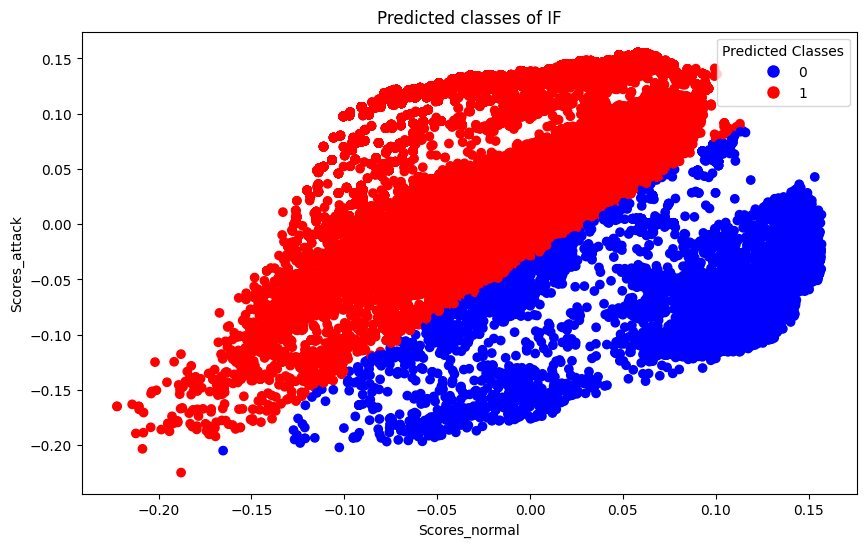

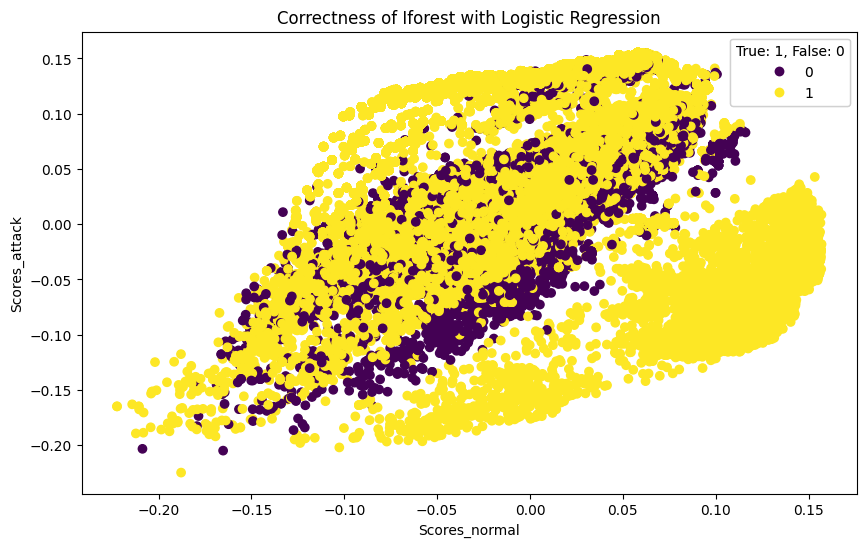

In [48]:
# ロジスティック回帰モデルの作成
model_LR = LogisticRegression()
model_LR.fit(scores_train, y_train)

# ラベルの予測
y_pred = model_LR.predict(scores)
#print(f"y_pred: {y_pred}")
print(f"Accuracy of Iforest with LogisticRegression: {accuracy_score(y_test, y_pred)}")

# 予測したラベルをプロット
# 予測したラベルをプロット
colors = {0: "blue", 1: "red"}  # クラスごとの色を指定
color_list = [colors[label] for label in y_pred]
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=color_list)
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
plt.title("Predicted classes of IF")
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{i}') for i, color in colors.items()]
plt.legend(handles=handles, loc="upper right", title="Predicted Classes")
plt.show()

# 正解不正解をプロット
labels = np.where(y_test == y_pred, 1, 0) # 1: 正解, 0: 不正解

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_attack")
plt.title("Correctness of Iforest with Logistic Regression")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()

# 結果の保存
save_results(results, "with LogisticRegression", y_test, y_pred)


                                  model  accuracy  precision  recall      f1
0                                 naive    0.7506     0.7949  0.7506  0.7526
1  no selection with LogisticRegression    0.8685     0.8666  0.8685  0.8666
2                     feature selection    0.8216     0.9085  0.8216  0.8545
3               with LogisticRegression    0.9076     0.9101  0.9076  0.9047


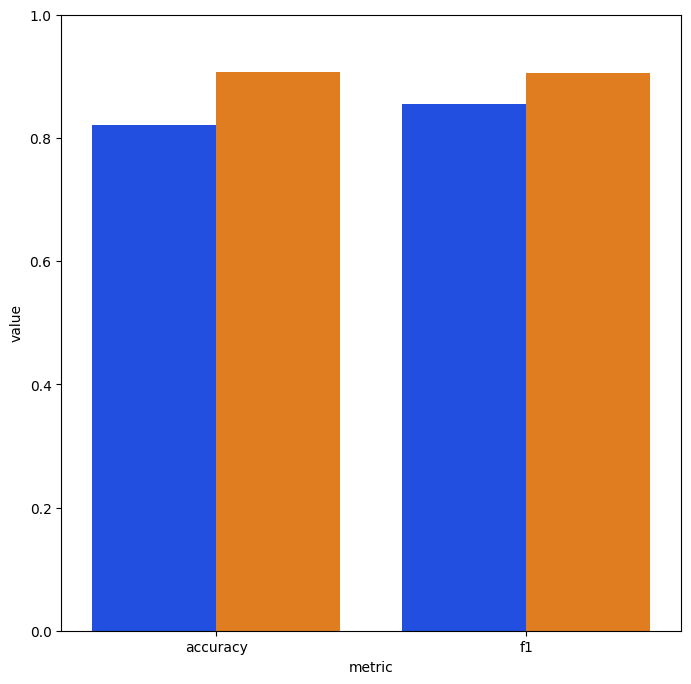

In [49]:
# 結果の表示
results = pd.DataFrame(results)
results = results.round(4)
print(results)

# model2とmodel3のみをフィルタリング
results_filtered = results[results["model"].isin(["feature selection", "with LogisticRegression"])]

# データを長い形式に変換
df_melted = results_filtered.melt(id_vars=["model"], var_name="metric", value_name="value")

# f値とaccuracyのみをフィルタリング
df_filtered = df_melted[df_melted["metric"].isin(["f1", "accuracy"])]

# 棒グラフを作成
plt.figure(figsize=(8, 8))
sns.barplot(data=df_filtered, x="metric", y="value", hue="model", palette="bright")
plt.ylim(0, 1)

# 凡例を非表示にする
plt.legend([],[], frameon=False)
plt.show()
